# Metricas, Generación y Pre-Post Pipeline para TDZDD

Por: Carlos Olguin - MSC

Leyendo: resultados_test/memoria_log.csv


C:\Users\carlo\AppData\Local\Temp\ipykernel_32832\333818697.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


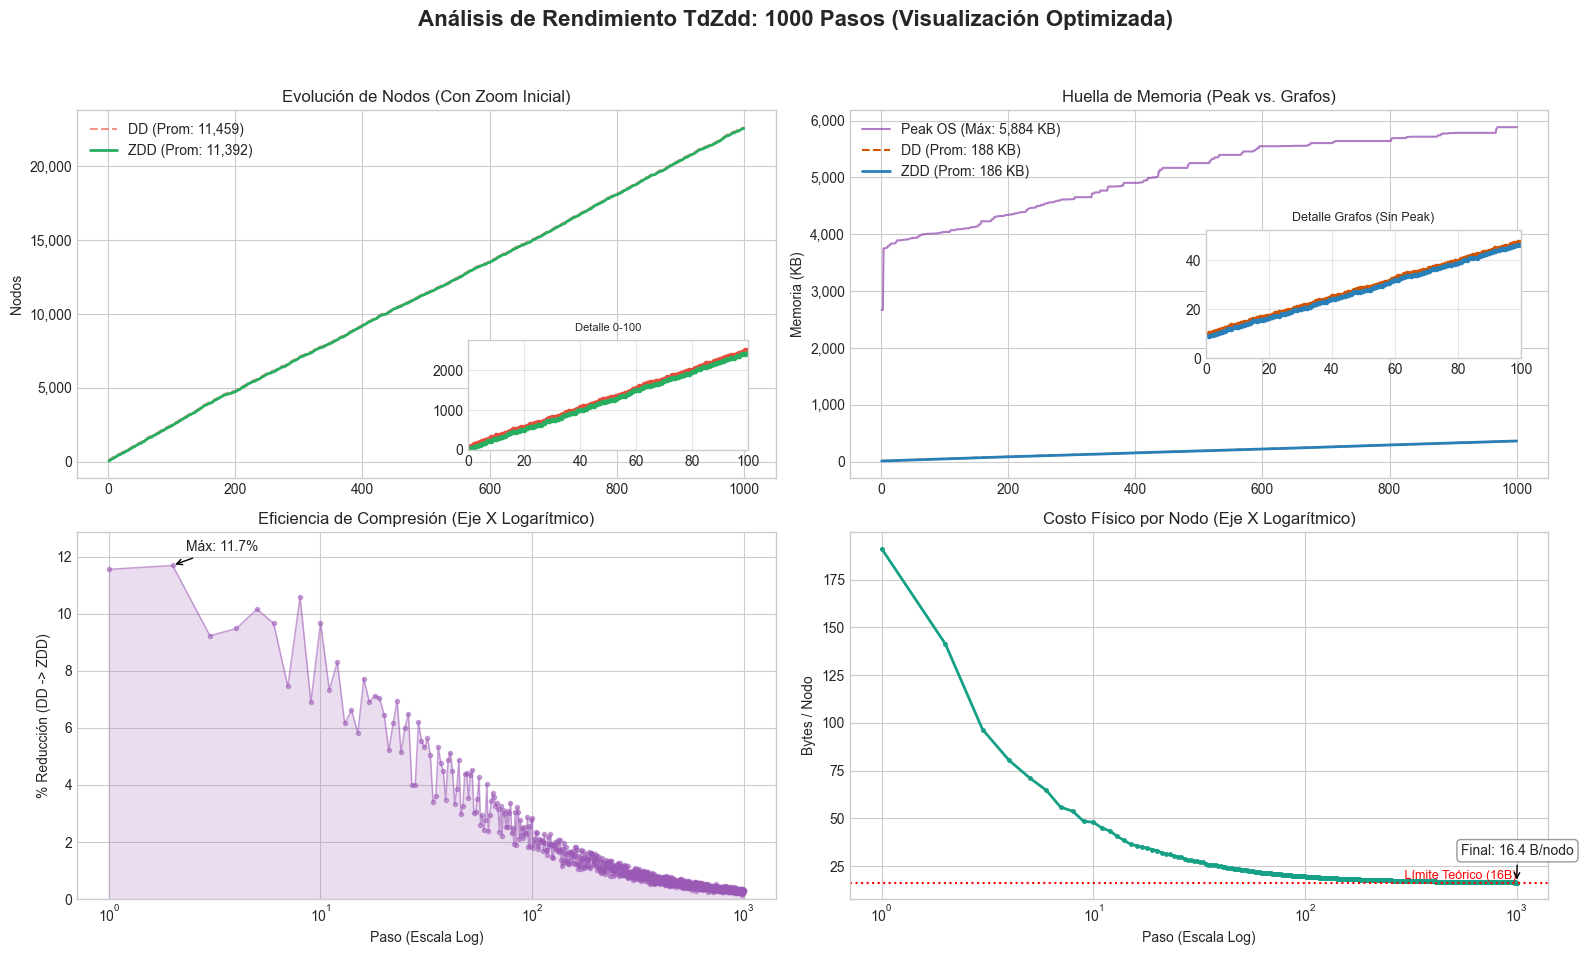

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

# Path archivos
OUTPUT_DIR = "resultados_test/"
CSV_FILE = "memoria_log.csv"
CSV_PATH = os.path.join(OUTPUT_DIR, CSV_FILE)

if not os.path.exists(CSV_PATH):
    print(f"Error: No se encontró {CSV_PATH}")
    exit()

print(f"Leyendo: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

# Cálculos
df['Reduccion_Pct'] = ((df['Bytes_DD'] - df['Bytes_ZDD']) / df['Bytes_DD']) * 100
df['Bytes_Por_Nodo'] = df['Bytes_ZDD'] / df['Nodos_ZDD']

# Estilo
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')

C_DD   = '#e74c3c'  
C_ZDD  = '#27ae60'  
C_MEM_DD = '#d35400' 
C_MEM_Z = '#2980b9' 
C_PEAK  = '#8e44ad' 
C_EFF   = '#9b59b6' 
C_DENS  = '#16a085' 

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Análisis de Rendimiento TdZdd: {len(df)} Pasos (Visualización Optimizada)', fontsize=16, fontweight='bold')
fmt_miles = ticker.StrMethodFormatter('{x:,.0f}')

# Calcular rango del zoom, se plantean minimo 100 conjuntos (pasos) o 50% si tiene menos
pasos = int(min(100, len(df) * 0.5))

# Promedios
avg_nodos_dd = df['Nodos_DD'].mean()
avg_nodos_zdd = df['Nodos_ZDD'].mean()
avg_mem_dd = df['KB_DD'].mean()
avg_mem_zdd = df['KB_ZDD'].mean()
max_peak = df['Peak_Mem_KB'].max()

# EVOLUCIÓN ESTRUCTURAL, OSEA LOS NODOS (Con ZOOM INSET)
ax1 = axs[0, 0]
ax1.plot(df['Paso'], df['Nodos_DD'], label=f'DD (Prom: {avg_nodos_dd:,.0f})', color=C_DD, linestyle='--', alpha=0.6)
ax1.plot(df['Paso'], df['Nodos_ZDD'], label=f'ZDD (Prom: {avg_nodos_zdd:,.0f})', color=C_ZDD, linewidth=2)
ax1.fill_between(df['Paso'], df['Nodos_DD'], df['Nodos_ZDD'], color=C_DD, alpha=0.1)

ax1.set_title('Evolución de Nodos (Con Zoom Inicial)', fontsize=12)
ax1.set_ylabel('Nodos')
ax1.legend(loc='upper left')
ax1.yaxis.set_major_formatter(fmt_miles)

axins1 = inset_axes(ax1, width="40%", height="30%", loc='lower right', borderpad=2)
axins1.plot(df['Paso'], df['Nodos_DD'], color=C_DD, linestyle='--', marker='.')
axins1.plot(df['Paso'], df['Nodos_ZDD'], color=C_ZDD, marker='.')
axins1.fill_between(df['Paso'], df['Nodos_DD'], df['Nodos_ZDD'], color=C_DD, alpha=0.1)
axins1.set_xlim(0, pasos) 
axins1.set_ylim(0, df['Nodos_DD'].iloc[pasos] * 1.1) 
axins1.grid(True, alpha=0.5)
axins1.set_title(f"Detalle 0-{pasos}", fontsize=8)

# CONSUMO MEMORIA (Con ZOOM INSET)
ax2 = axs[0, 1]

ax2.plot(df['Paso'], df['Peak_Mem_KB'], label=f'Peak OS (Máx: {max_peak:,.0f} KB)', 
         color=C_PEAK, linestyle='-', linewidth=1.5, alpha=0.7)
ax2.plot(df['Paso'], df['KB_DD'], label=f'DD (Prom: {avg_mem_dd:,.0f} KB)', color=C_MEM_DD, linestyle='--')
ax2.plot(df['Paso'], df['KB_ZDD'], label=f'ZDD (Prom: {avg_mem_zdd:,.0f} KB)', color=C_MEM_Z, linewidth=2)

ax2.set_title('Huella de Memoria (Peak vs. Grafos)', fontsize=12)
ax2.set_ylabel('Memoria (KB)')
ax2.legend(loc='upper left')
ax2.yaxis.set_major_formatter(fmt_miles)

axins2 = inset_axes(ax2, width="45%", height="35%", loc='center right', borderpad=2)
axins2.plot(df['Paso'], df['KB_DD'], color=C_MEM_DD, linestyle='--', marker='.', label='DD')
axins2.plot(df['Paso'], df['KB_ZDD'], color=C_MEM_Z, marker='.', label='ZDD')
axins2.fill_between(df['Paso'], df['KB_DD'], df['KB_ZDD'], color=C_MEM_DD, alpha=0.2)

axins2.set_xlim(0, pasos)
ymax_zoom = df['KB_DD'].iloc[pasos] * 1.1 
axins2.set_ylim(0, ymax_zoom)
axins2.grid(True, alpha=0.5)
axins2.set_title(f"Detalle Grafos (Sin Peak)", fontsize=9)

# EFICIENCIA (EJE X LOGARÍTMICO Para visualizacion)
ax3 = axs[1, 0]
ax3.semilogx(df['Paso'], df['Reduccion_Pct'], color=C_EFF, linewidth=1, marker='o', markersize=3, alpha=0.5)
ax3.fill_between(df['Paso'], df['Reduccion_Pct'], color=C_EFF, alpha=0.2)

ax3.set_title('Eficiencia de Compresión (Eje X Logarítmico)', fontsize=12)
ax3.set_ylabel('% Reducción (DD -> ZDD)')
ax3.set_xlabel('Paso (Escala Log)')
ax3.set_ylim(0, max(df['Reduccion_Pct']) * 1.1)

max_eff = df['Reduccion_Pct'].max()
max_eff_idx = df['Reduccion_Pct'].idxmax()
ax3.annotate(f'Máx: {max_eff:.1f}%', 
             xy=(df['Paso'][max_eff_idx], max_eff), 
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'))

# DENSIDAD (EJE X LOGARÍTMICO Para visualizacion)
ax4 = axs[1, 1]
ax4.semilogx(df['Paso'], df['Bytes_Por_Nodo'], color=C_DENS, linewidth=2, marker='.', markersize=5)

ax4.axhline(y=16, color='r', linestyle=':', label='Payload (16B)')
ax4.text(df['Paso'].iloc[-1], 16.5, ' Límite Teórico (16B)', color='r', va='bottom', ha='right', fontsize=9)

ax4.set_title('Costo Físico por Nodo (Eje X Logarítmico)', fontsize=12)
ax4.set_ylabel('Bytes / Nodo')
ax4.set_xlabel('Paso (Escala Log)')

val_final = df['Bytes_Por_Nodo'].iloc[-1]
ax4.annotate(f'Final: {val_final:.1f} B/nodo', 
             xy=(df['Paso'].iloc[-1], val_final), 
             xytext=(-40, 20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'),
             bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Recordar la compresión es dependiente del dataset, los ZDD funcionan bien para conjuntos mas sparse (dispersos), es decir, hay que tener en cuenta el universo y los elementos en el total de estos!

Probando mismo codigo en otro test ya planteado mas disperso observamos la mejora clara buscada:

Leyendo: resultados_test/memoria_log_2.csv


C:\Users\carlo\AppData\Local\Temp\ipykernel_32832\2581212221.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


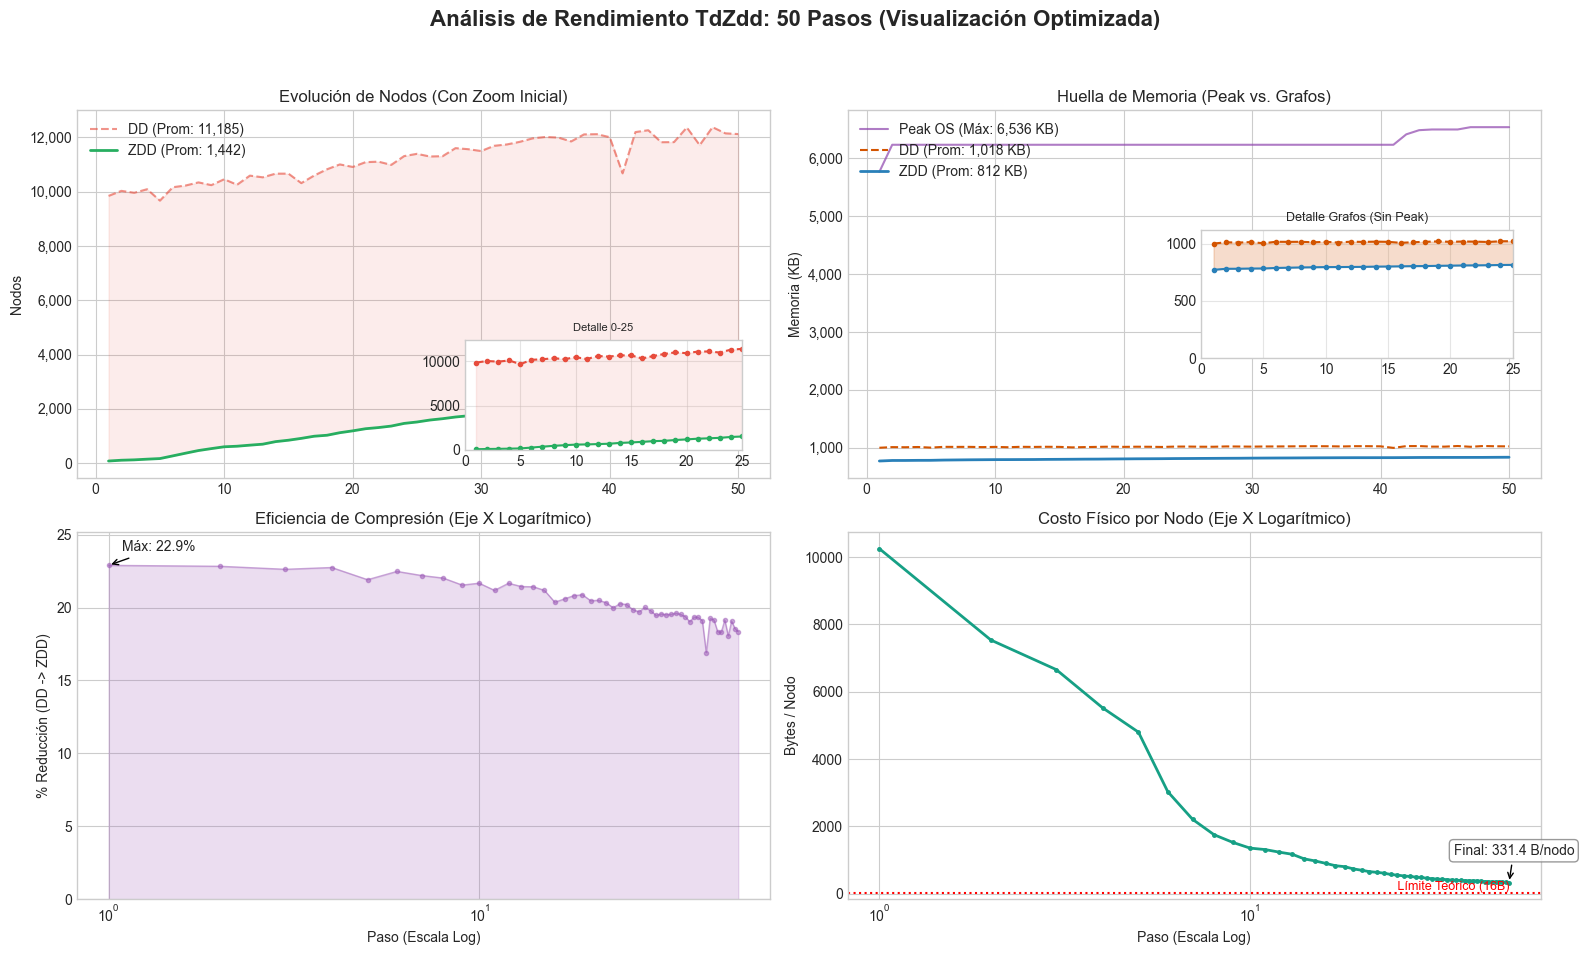

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

# Path archivos
OUTPUT_DIR = "resultados_test/"
CSV_FILE = "memoria_log_2.csv"
CSV_PATH = os.path.join(OUTPUT_DIR, CSV_FILE)

if not os.path.exists(CSV_PATH):
    print(f"Error: No se encontró {CSV_PATH}")
    exit()

print(f"Leyendo: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

# Cálculos
df['Reduccion_Pct'] = ((df['Bytes_DD'] - df['Bytes_ZDD']) / df['Bytes_DD']) * 100
df['Bytes_Por_Nodo'] = df['Bytes_ZDD'] / df['Nodos_ZDD']

# Estilo
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('ggplot')

C_DD   = '#e74c3c'  
C_ZDD  = '#27ae60'  
C_MEM_DD = '#d35400' 
C_MEM_Z = '#2980b9' 
C_PEAK  = '#8e44ad' 
C_EFF   = '#9b59b6' 
C_DENS  = '#16a085' 

fig, axs = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Análisis de Rendimiento TdZdd: {len(df)} Pasos (Visualización Optimizada)', fontsize=16, fontweight='bold')
fmt_miles = ticker.StrMethodFormatter('{x:,.0f}')

# Calcular rango del zoom, se plantean minimo 100 conjuntos (pasos) o 50% si tiene menos
pasos = int(min(100, len(df) * 0.5))

# Promedios
avg_nodos_dd = df['Nodos_DD'].mean()
avg_nodos_zdd = df['Nodos_ZDD'].mean()
avg_mem_dd = df['KB_DD'].mean()
avg_mem_zdd = df['KB_ZDD'].mean()
max_peak = df['Peak_Mem_KB'].max()

# EVOLUCIÓN ESTRUCTURAL, OSEA LOS NODOS (Con ZOOM INSET)
ax1 = axs[0, 0]
ax1.plot(df['Paso'], df['Nodos_DD'], label=f'DD (Prom: {avg_nodos_dd:,.0f})', color=C_DD, linestyle='--', alpha=0.6)
ax1.plot(df['Paso'], df['Nodos_ZDD'], label=f'ZDD (Prom: {avg_nodos_zdd:,.0f})', color=C_ZDD, linewidth=2)
ax1.fill_between(df['Paso'], df['Nodos_DD'], df['Nodos_ZDD'], color=C_DD, alpha=0.1)

ax1.set_title('Evolución de Nodos (Con Zoom Inicial)', fontsize=12)
ax1.set_ylabel('Nodos')
ax1.legend(loc='upper left')
ax1.yaxis.set_major_formatter(fmt_miles)

axins1 = inset_axes(ax1, width="40%", height="30%", loc='lower right', borderpad=2)
axins1.plot(df['Paso'], df['Nodos_DD'], color=C_DD, linestyle='--', marker='.')
axins1.plot(df['Paso'], df['Nodos_ZDD'], color=C_ZDD, marker='.')
axins1.fill_between(df['Paso'], df['Nodos_DD'], df['Nodos_ZDD'], color=C_DD, alpha=0.1)
axins1.set_xlim(0, pasos) 
axins1.set_ylim(0, df['Nodos_DD'].iloc[pasos] * 1.1) 
axins1.grid(True, alpha=0.5)
axins1.set_title(f"Detalle 0-{pasos}", fontsize=8)

# CONSUMO MEMORIA (Con ZOOM INSET)
ax2 = axs[0, 1]

ax2.plot(df['Paso'], df['Peak_Mem_KB'], label=f'Peak OS (Máx: {max_peak:,.0f} KB)', 
         color=C_PEAK, linestyle='-', linewidth=1.5, alpha=0.7)
ax2.plot(df['Paso'], df['KB_DD'], label=f'DD (Prom: {avg_mem_dd:,.0f} KB)', color=C_MEM_DD, linestyle='--')
ax2.plot(df['Paso'], df['KB_ZDD'], label=f'ZDD (Prom: {avg_mem_zdd:,.0f} KB)', color=C_MEM_Z, linewidth=2)

ax2.set_title('Huella de Memoria (Peak vs. Grafos)', fontsize=12)
ax2.set_ylabel('Memoria (KB)')
ax2.legend(loc='upper left')
ax2.yaxis.set_major_formatter(fmt_miles)

axins2 = inset_axes(ax2, width="45%", height="35%", loc='center right', borderpad=2)
axins2.plot(df['Paso'], df['KB_DD'], color=C_MEM_DD, linestyle='--', marker='.', label='DD')
axins2.plot(df['Paso'], df['KB_ZDD'], color=C_MEM_Z, marker='.', label='ZDD')
axins2.fill_between(df['Paso'], df['KB_DD'], df['KB_ZDD'], color=C_MEM_DD, alpha=0.2)

axins2.set_xlim(0, pasos)
ymax_zoom = df['KB_DD'].iloc[pasos] * 1.1 
axins2.set_ylim(0, ymax_zoom)
axins2.grid(True, alpha=0.5)
axins2.set_title(f"Detalle Grafos (Sin Peak)", fontsize=9)

# EFICIENCIA (EJE X LOGARÍTMICO Para visualizacion)
ax3 = axs[1, 0]
ax3.semilogx(df['Paso'], df['Reduccion_Pct'], color=C_EFF, linewidth=1, marker='o', markersize=3, alpha=0.5)
ax3.fill_between(df['Paso'], df['Reduccion_Pct'], color=C_EFF, alpha=0.2)

ax3.set_title('Eficiencia de Compresión (Eje X Logarítmico)', fontsize=12)
ax3.set_ylabel('% Reducción (DD -> ZDD)')
ax3.set_xlabel('Paso (Escala Log)')
ax3.set_ylim(0, max(df['Reduccion_Pct']) * 1.1)

max_eff = df['Reduccion_Pct'].max()
max_eff_idx = df['Reduccion_Pct'].idxmax()
ax3.annotate(f'Máx: {max_eff:.1f}%', 
             xy=(df['Paso'][max_eff_idx], max_eff), 
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'))

# DENSIDAD (EJE X LOGARÍTMICO Para visualizacion)
ax4 = axs[1, 1]
ax4.semilogx(df['Paso'], df['Bytes_Por_Nodo'], color=C_DENS, linewidth=2, marker='.', markersize=5)

ax4.axhline(y=16, color='r', linestyle=':', label='Payload (16B)')
ax4.text(df['Paso'].iloc[-1], 16.5, ' Límite Teórico (16B)', color='r', va='bottom', ha='right', fontsize=9)

ax4.set_title('Costo Físico por Nodo (Eje X Logarítmico)', fontsize=12)
ax4.set_ylabel('Bytes / Nodo')
ax4.set_xlabel('Paso (Escala Log)')

val_final = df['Bytes_Por_Nodo'].iloc[-1]
ax4.annotate(f'Final: {val_final:.1f} B/nodo', 
             xy=(df['Paso'].iloc[-1], val_final), 
             xytext=(-40, 20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='black'),
             bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.8))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()